In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.multiclass import unique_labels

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/dh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [4]:
dataset_path = os.path.join(os.getcwd(), '..', 'training.1600000.processed.noemoticon.csv.zip')
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [5]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [6]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 388 ms, sys: 7.28 ms, total: 395 ms
Wall time: 394 ms


In [7]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [8]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [9]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 36.2 s, sys: 71.4 ms, total: 36.3 s
Wall time: 36.3 s


In [10]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [11]:
df_test.head()

,target,ids,date,flag,user,text
541200,NEGATIVE,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,ahhh hope ok
750,NEGATIVE,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,cool tweet apps razr 2
766711,NEGATIVE,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,know family drama lame hey next time u hang ki...
285055,NEGATIVE,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,school email open geography stuff revise stupi...
705995,NEGATIVE,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


# Evaluation

In [27]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [38]:
def decode_sentiment_w2v_lstm(score, include_neutral=False):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 'NEGATIVE'
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 'POSITIVE'

        return label
    else:
        return 'NEGATIVE' if score < 0.5 else 'POSITIVE'
    
def decode_sentiment_vader(score, include_neutral=False):
    if score > 0:
        label = 'POSITIVE'
    elif score < 0:
        label = 'NEGATIVE'
    else:
        label = 'POSITIVE'
        
    return label

In [14]:
os.chdir(os.path.join(os.getcwd(), '..'))

In [15]:
from W2Vec_LSTM_Sentiment_Engine.w2v_lstm import build_w2v_lstm_and_tokenizer, predict
from NLTKVader import vader_compound_score

In [16]:
tokenizer, model = build_w2v_lstm_and_tokenizer()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2019-11-07 14:35:44,486 : WARNING : From /home/dh/anaconda3/envs/twitter_sentiment/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-11-07 14:35:45,819 : WARNING : From /home/dh/anaconda3/envs/twitter_sentiment/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# W2v LSTM Test

In [17]:
%%time
y_test_1d = list(df_test.target)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)
scores = model.predict(x_test, verbose=1, batch_size=8000)
w2v_pred_1d = [decode_sentiment_w2v_lstm(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 32s 99us/sample
CPU times: user 25.2 s, sys: 1.62 s, total: 26.8 s
Wall time: 36.1 s


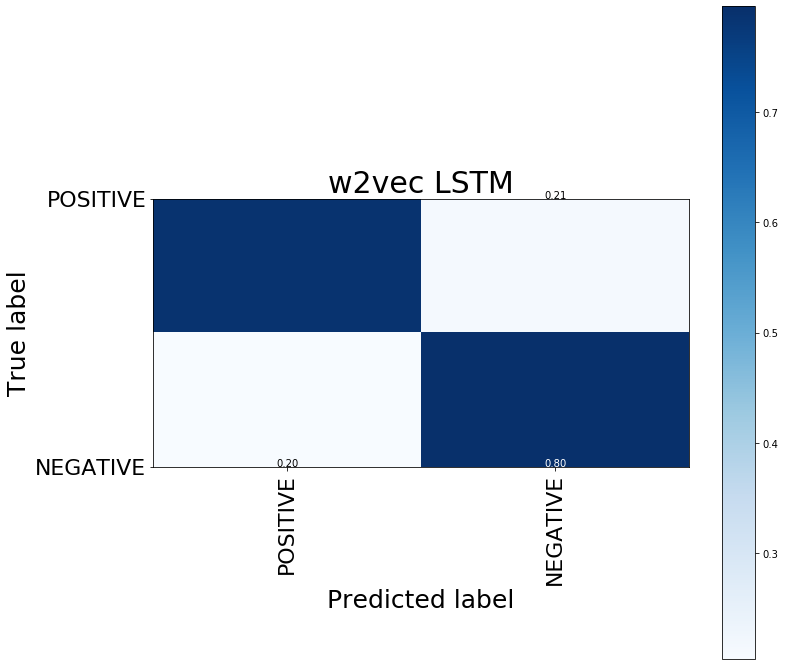

CPU times: user 698 ms, sys: 15.1 ms, total: 713 ms
Wall time: 711 ms


In [31]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, w2v_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="w2vec LSTM")
plt.show()

In [19]:
print(classification_report(y_test_1d, w2v_pred_1d))
print(accuracy_score(y_test_1d, w2v_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.79      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000

0.791134375


# Vader Test

In [39]:
%%time
y_test_1d = list(df_test.target)
# scores = [vader_compound_score(txt) for txt in df_test.text]
vader_pred_1d = [decode_sentiment_vader(score, include_neutral=False) for score in scores]

CPU times: user 56.3 ms, sys: 0 ns, total: 56.3 ms
Wall time: 55.3 ms


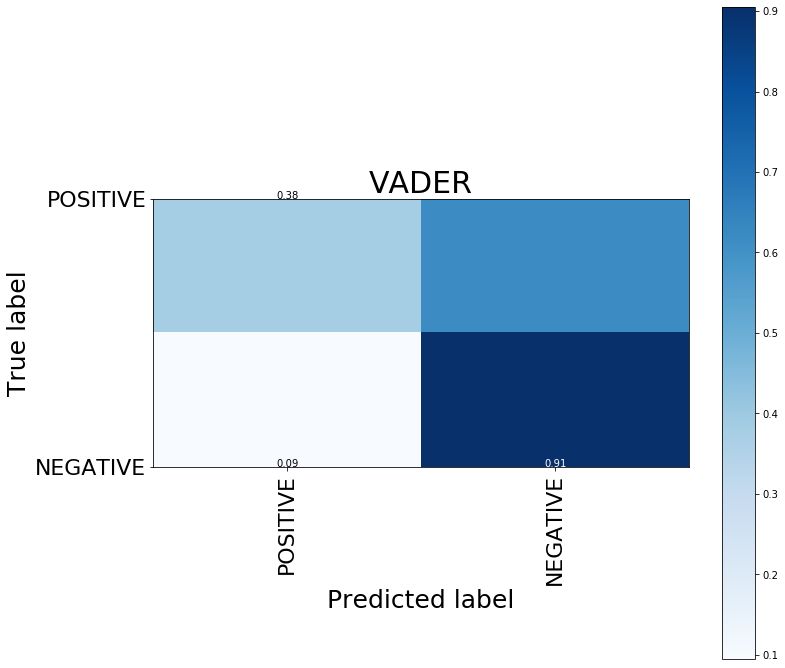

CPU times: user 700 ms, sys: 19.6 ms, total: 720 ms
Wall time: 718 ms


In [40]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, vader_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="VADER")
plt.show()

In [41]:
print(classification_report(y_test_1d, vader_pred_1d))
print(accuracy_score(y_test_1d, vader_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.38      0.52    159494
    POSITIVE       0.60      0.91      0.72    160506

    accuracy                           0.64    320000
   macro avg       0.70      0.64      0.62    320000
weighted avg       0.70      0.64      0.62    320000

0.64465625


In [42]:
print(cnf_matrix)

[[ 60977  98517]
 [ 15193 145313]]
